# Pulse sequence creation

Link [here](https://pulser.readthedocs.io/en/stable/tutorials/creating.html)

The idea of the managing of netral atoms (and thus, from that obtain quantum operations to qubits) is:
- obtain the grid of your qubits (the object for a lattice of qubits is called `Register`)
- create and design pulses which will act on the atom array (the object for a pulse is called `Pulse`)
- define how the pulses act on each atoms, in what order (each pulse acts on a set of atoms at a certain moment of time) (the object for these instrauctions is called `Sequence`)

In [1]:
import numpy as np
import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register

## 1. Creating the `Register`

The `Register` defines the positions of the atoms and their names of each one. 

There are multiple ways of defining creating a `Register`, the most customizable one being to create a dictionary that associates a name (the key) to a cooordinate (the value).

In this example we will consider how to define in different ways a 4x4 square lattice

- create the register through a dictionary of {keys=numbers, values=arrays taken moving along axis-0 of a 2-D array (a matrix) (i.e. along rows)}

In [2]:
L = 4
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype = float) # make a 2-D array (i.e a matrix) which corresponds to 16x2 elements, where each couple will represent a coordinate on a plane
square -= np.mean(square, axis=0) # to have them centered in (0,0) of the grid
square *= 5 # to have the image bigger (distantiate more to each other)
qubits = dict(enumerate(square)) # create a dictionary which associate to each couple (the value) a number (the key)
reg1 = Register(qubits) # initialize this dictionary, with names and cooridnates as 2-elemnents vecotors, as a Pulser Register

reg1:


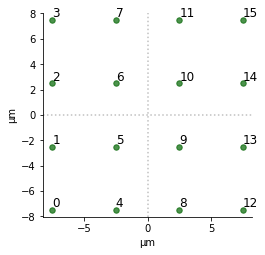

In [3]:
print("reg1:")
reg1.draw()

- create the register through list (or array) of plane cooridnates (i.e sequence of elements which contains two values)

In [79]:
L = 4
square = np.array([[i, j] for i in range(L) for j in range(L)], dtype = float) # make a 2-D array (i.e a matrix) which corresponds to 16x2 elements, where each couple will represent a coordinate on a plane
square -= np.mean(square, axis=0) # to have them centered in (0,0) of the grid
square *= 5 # to have the image bigger (distantiate more to each other)
reg2 = Register.from_coordinates(square, prefix='q')

reg2:


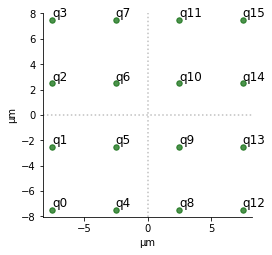

In [80]:
print("reg2:")
reg2.draw()

- use built-in class methods from creation of common array patterns 
    - square lattices (rectangualar or square shapes)
    - triangular lattices 

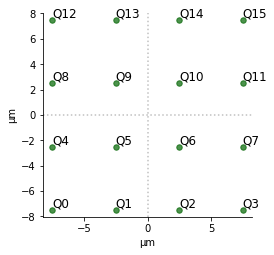

In [52]:
reg3 = Register.square(4, spacing=5, prefix='Q') # 4x4 array with atoms 5um apart
reg3.draw()

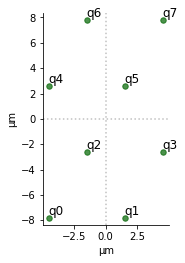

In [101]:
reg4 = Register.triangular_lattice(rows=4, atoms_per_row=2, spacing=6, prefix='q')
reg4.draw()

## 2. Create `Pulse` objects

A pulse is defined by
- frequency (in theory of neutral atoms, or to be more specific, Rydberg Atoms, it's a **Rabi frequency**)
- detuning
- time of application (how much it lasts)

And can be
- constant
- not constant

I) first we will create a simple constant pulse with a constant Rabi frequency of 2 rad/µs and a constant detuning of -10 rad/µs that lasts 200 ns.

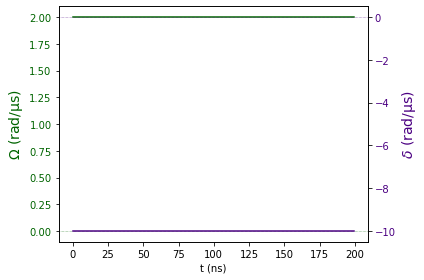

In [4]:
simple_pulse = Pulse.ConstantPulse(duration=200,amplitude=2,detuning=-10,phase=0)
simple_pulse.draw()

II) now we want to create a more complex pulse where the amplitude and the detuning are not constant. To do that, we use `Waveforms` `pulser` objects:

In [5]:
from pulser.waveforms import RampWaveform, BlackmanWaveform

duration = 1000
amp_wf = BlackmanWaveform(duration, np.pi/2)  # Duration: 1000 ns, Area: pi/2 (This is the not-constant Rabi frequency)
detuning_wf = RampWaveform(duration, -20, 20) # Duration: 1000ns, linear sweep from -20 to 20 rad/µs (This is the not-constant detuning)

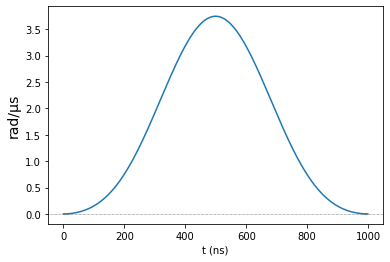

In [35]:
amp_wf.draw()

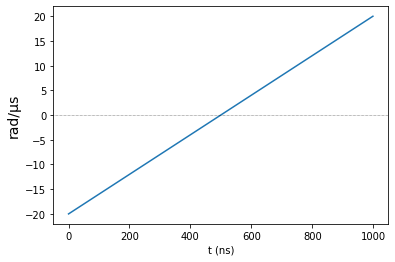

In [36]:
detuning_wf.draw()

Also, it is often convenient to find the integral of a waveform, which can be obtain by calling:

In [37]:
amp_wf.integral # which is pi/2 as we have defined it

1.5707963267948968

We then create the pulse with the waveforms instead of fixed values and we can also visualize it:

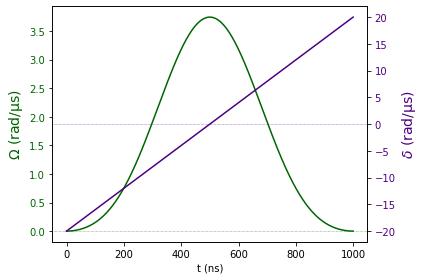

In [6]:
complex_pulse = Pulse(amp_wf, detuning_wf, phase=0)
complex_pulse.draw()

## 3. Initializing the `Sequence`

A sequence tells how the pulses behaves:
- which pulse acts on which atoms
- in what order they acts

The entire Sequence is stored by Pulser and can then be either
- simulated
- sent to a real device.

To create a `Sequence`, one has to provide it with 
- the `Register` instance
- the device in which the sequence will be executed. (The chosen device will dictate whether the register is valid or not.)

Thus, on overall, A sequence is composed by

        The device in which we want to implement it

        The register of qubits on which to act

        The device’s channels that are used

        The schedule of operations on each channel

We import the device (in this case, Chadoq2) from `pulser.devices` and initialize our sequence with the freshly created register:

In [7]:
from pulser.devices import Chadoq2

reg = Register.square(4, spacing=5, prefix='q')

seq = Sequence(reg, Chadoq2)

### 3.1 Declaring the channels that will be used

As said, in a sequence we choose which pulses act on which atoms, so first we have to choose the targets of the pulses:

the idea is that we choose a channel (through which the pulse will be sent) which will be adressed to one ore more atoms, and we have two kinds of channels
- local: adress one atom at a time
- global: adress all the atoms (the qubits) in the device

1. First we have to check which channels are available in the device choosen (in our case Chadoq2):

In [23]:
seq.available_channels

{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg'),
 'raman_local': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'digital')}

We are going to choose the `'rydberg_local'` and the `'raman_local'` channles

In [8]:
seq.declare_channel('ch0', 'raman_local')

In [25]:
print("Available channels after declaring 'ch0':")
pprint(seq.available_channels)

Available channels after declaring 'ch0':
{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg')}


In [9]:
seq.declare_channel('ch1', 'rydberg_local', initial_target='q4') # here the target of channel 'ch1' has been set during its declaration to the qubit of the register reg, named 'q4'

In [27]:
print("Available channels after declaring 'ch1':")
pprint(seq.available_channels)

Available channels after declaring 'ch1':
{'rydberg_global': Rydberg.Global(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 15.707963267948966 rad/µs, Basis: 'ground-rydberg')}


**Note**: how a declared channel is no longer reported as available.

**NOTE**: to reset the declared channels for a sequence object, re initialize it:

`seq = Sequence(register_name, device_name)`

At any time, we can also consult which channels were declared, their specifications and the name they were given by calling:

In [28]:
seq.declared_channels

{'ch0': Raman.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'digital'),
 'ch1': Rydberg.Local(Max Absolute Detuning: 125.66370614359172 rad/µs, Max Amplitude: 62.83185307179586 rad/µs, Target time: 220 ns, Basis: 'ground-rydberg')}

**Every channel need to start with a target**
- gloabl channel: the target is predefined to be all the qubits in the device
- local channel: 
    - can be done during declaration (as here was done for `'ch1'`)
    - can be done through the standard `target` method

In [10]:
seq.target('q1', 'ch0')

Now both channels have an initial target, so we can start building the sequence.

### 3.2 Composing the sequence

As we have already mentioned, the idea is:
1. have a register
2. create the desired pulses
3. create a sequence of pulses which
    - acts on certain atoms (dictated by the chosen channel to which is assingegned the pulse and the targeted atom)
    - in a precise order 

#### 3.2.1 Say to the channel
- which pulse to use (with the method `add` of the `sequence` object)
- which atom to target (with the method `target` of the `sequence` object)
- when (with the method `delay` of the `sequence` object)

Below is the example of a sequence sending the same -pulse to two atoms, sequentially, using the same channel.

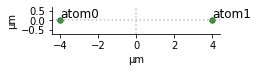

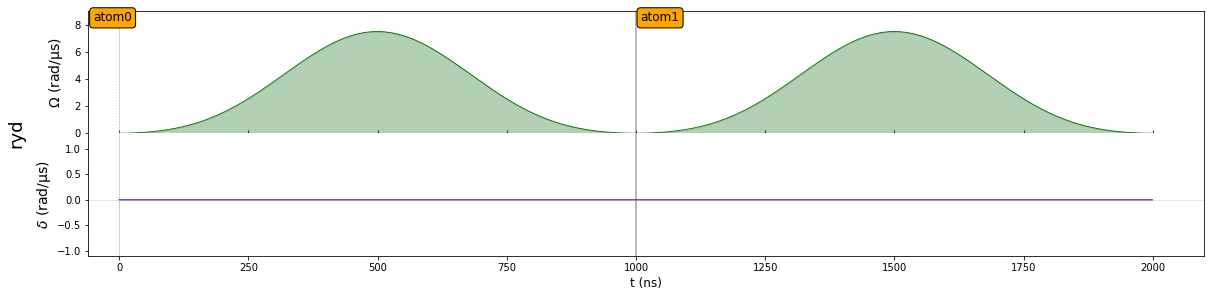

In [15]:
from pulser import Sequence

reg_example = Register.rectangle(1, 2, spacing=8, prefix='atom')
reg_example.draw()

from pulser.waveforms import RampWaveform, BlackmanWaveform

pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration=1000, area=np.pi), 0., 0.)

seq_example = Sequence(reg, Chadoq2)

seq_example.declare_channel('ryd','rydberg_local','atom0')

seq_example.add(pi_pulse,'ryd')
seq_example.target('atom1', 'ryd')
seq_example.add(pi_pulse,'ryd')

seq_example.draw()

Let's consider another situation when we use the sequence object the register and the pulses created in the previous points

We add the `simple_pulse` to `ch0`

In [11]:
seq.add(simple_pulse, 'ch0')

Now, say we want to idle `'ch1'` for $100 \,ns$ while `'ch0'` is doing its pulse. We do that by calling:

In [12]:
seq.delay(100, 'ch1')

and then we add the `complex_pulse` to the `ch1`

In [13]:
seq.add(complex_pulse, 'ch1')

Let’s check the schedule to see how this is looking:

In [41]:
print(seq)

Channel: ch0
t: 0 | Initial targets: q1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q1

Channel: ch1
t: 0 | Initial targets: q4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4




We can also draw the sequence, for a more visual representation:

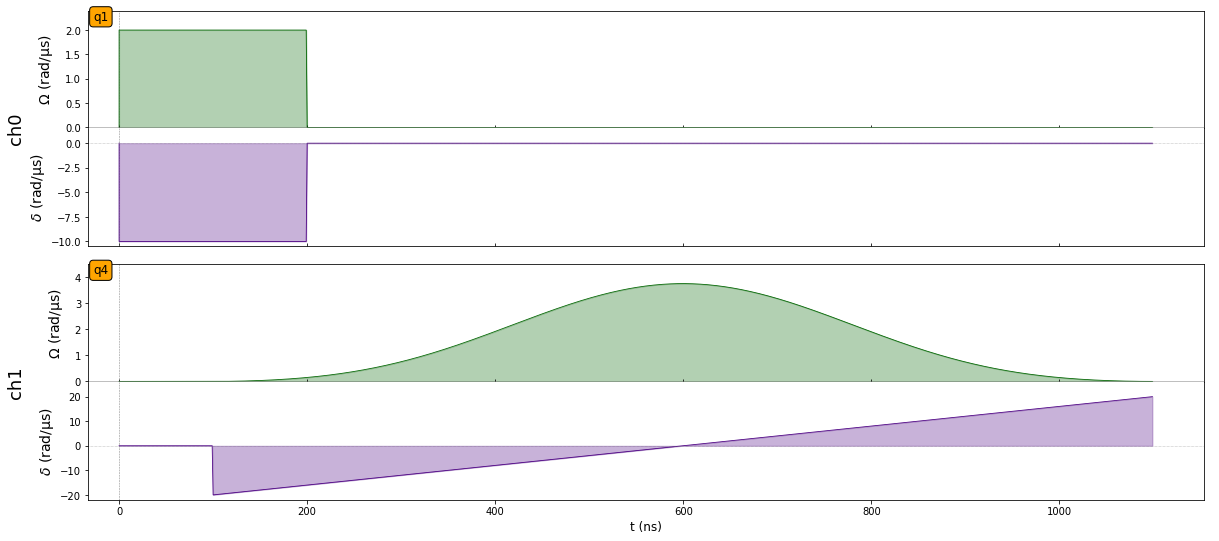

In [42]:
seq.draw()

#### 3.2.2 handling the order of the actions that each channel preform to their targeted qubits (handled with the argument `protocol` of the `sequence.add()` method)

The `protocol` argument of the `seq.add()` method

protocol (str, default='min-delay'): Stipulates how to deal with
        eventual conflicts with other channels, specifically in terms
        of having multiple channels act on the same target
        simultaneously.

        - ``'min-delay'``: Before adding the pulse, introduces the
          smallest possible delay that avoids all exisiting conflicts.

        - ``'no-delay'``: Adds the pulse to the channel, regardless of
          existing conflicts.

        - ``'wait-for-all'``: Before adding the pulse, adds a delay
          that idles the channel until the end of the other channels'
          latest pulse.

$I)$ Let's introduce the first protocol `min_delay` with the idea of importance of handling the order of when the pulses act (expecially when, different channels, would act on the same qubit(s), i.e. when there would be a **conflict**) 

##### Conflicts Handling

Now, let’s see how the `Sequence` builder handles **conflicts** (i.e. two channels acting on the same qubit at once).

We’re going to add a `complex_pulseto` `'ch0'`, but now we want to target it to qubit 4, which is the same target of `'ch1'`.

In [43]:
seq.target('q4', 'ch0')
seq.add(complex_pulse, 'ch0')

Current Schedule:
Channel: ch0
t: 0 | Initial targets: q1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q1
t: 200->220 | Target: q4 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4

Channel: ch1
t: 0 | Initial targets: q4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4




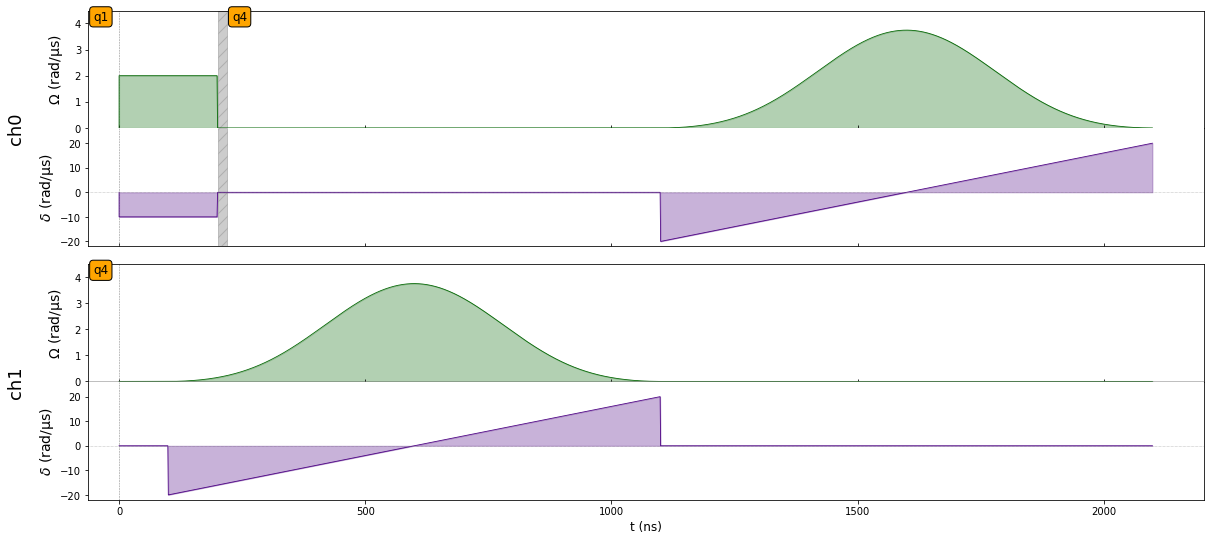

In [44]:
print("Current Schedule:")
print(seq)
seq.draw()

By looking at the current schedule, we can see that `'ch0'` was delayed from `ti=220` to `tf=1100`, and only then was the `complex_pulse` added. 

The reason for this is simple: it had to wait for the pulse on `ch1`, also targeted to qubit 4, to finish before it could apply its own. It behaved this way because, in `Sequence.add` there is a default argument `protocol='min-delay'`.

$II)$ Another protocol for pulse addition is `wait-for-all`, which makes the new pulse wait even if there is no conflict.

Let’s remove the conflict and add two `simple_pulses` to `ch1` with the different protocols to see how the compare.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: q1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q1
t: 200->220 | Target: q4 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4

Channel: ch1
t: 0 | Initial targets: q4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4
t: 1100->1100 | Target: q0 | Phase Reference: 0.0
t: 1100->1300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q0
t: 1300->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q0




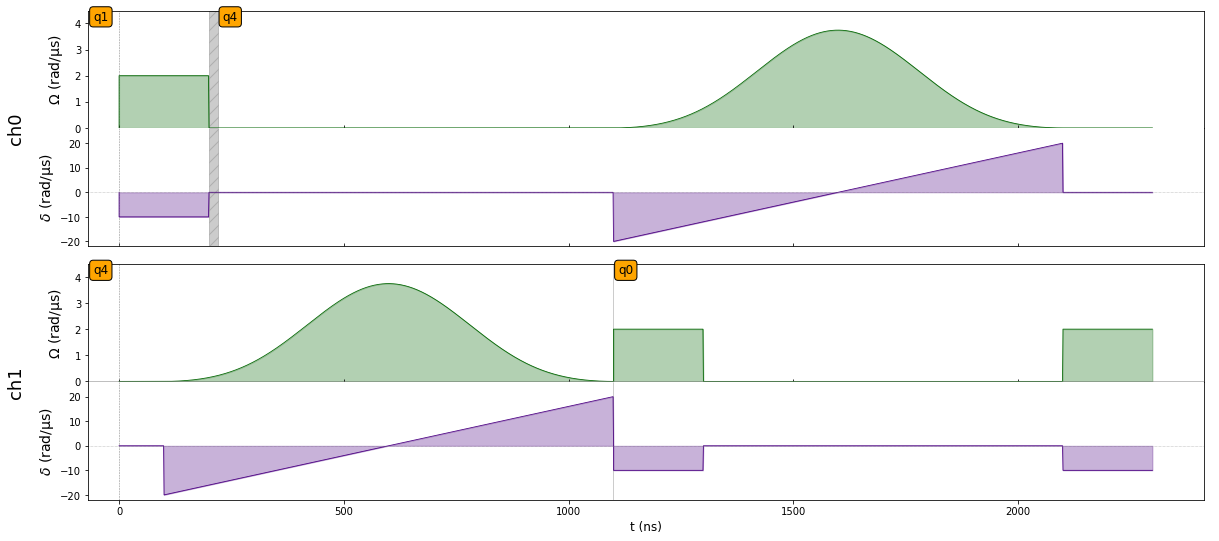

In [46]:
seq.target('q0', 'ch1')
seq.add(simple_pulse, 'ch1', protocol='min-delay')
seq.add(simple_pulse, 'ch1', protocol='wait-for-all')

print("Current Schedule:")
print(seq)
seq.draw()

Because we removed the conflict by changing the target of `ch1` to qubit `'q0'`, we see that the first pulse was added without delay from `ti=1100` to `tf=1300` (i.e. while `complex_pulse` is still running in `ch0`). However, once we changed to `protocol='wait-for-all'`, there is now a delay (from `ti=1300` to `tf=2100`) that idles `ch1` until `ch0` is finished with its pulse, even though there was no conflict.

$III)$ The third protocol is called `'no-delay'` which, as the name implies, never delays the channel where the pulse is being added, even if that means introducing a conflict.

Current Schedule:
Channel: ch0
t: 0 | Initial targets: q1 | Phase Reference: 0.0 
t: 0->200 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q1
t: 200->220 | Target: q4 | Phase Reference: 0.0
t: 220->1100 | Delay 
t: 1100->2100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4
t: 2100->2100 | Target: q0 | Phase Reference: 0.0
t: 2100->3100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q0

Channel: ch1
t: 0 | Initial targets: q4 | Phase Reference: 0.0 
t: 0->100 | Delay 
t: 100->1100 | Pulse(Amp=Blackman(Area: 1.57), Detuning=Ramp(-20->20 rad/µs), Phase=0) | Targets: q4
t: 1100->1100 | Target: q0 | Phase Reference: 0.0
t: 1100->1300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q0
t: 1300->2100 | Delay 
t: 2100->2300 | Pulse(Amp=2 rad/µs, Detuning=-10 rad/µs, Phase=0) | Targets: q0




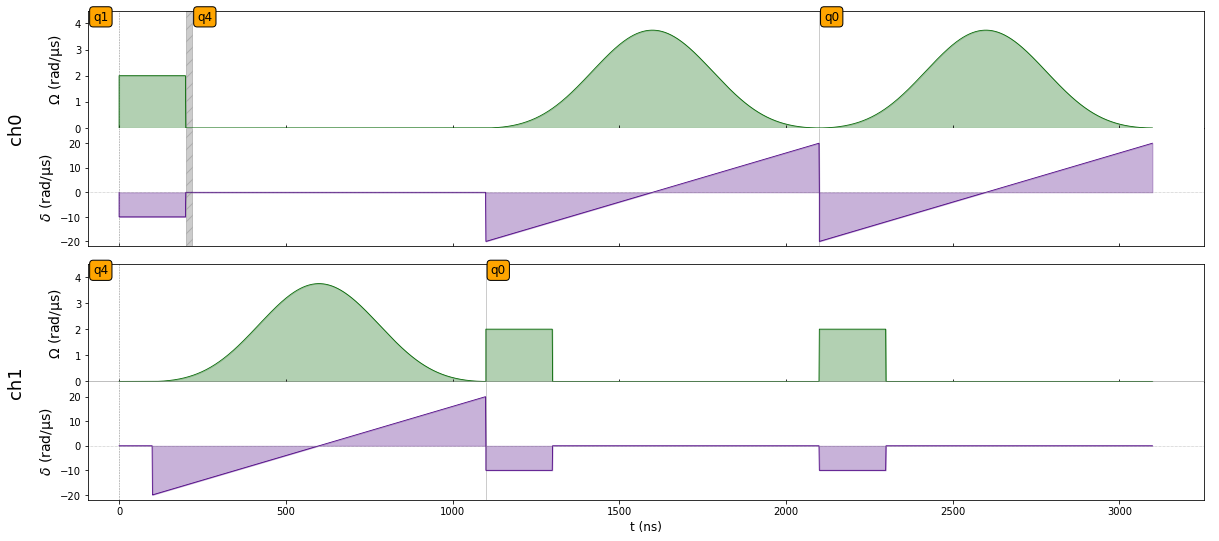

In [48]:
seq.target('q0', 'ch0')
seq.add(complex_pulse, 'ch0', protocol='no-delay')

print("Current Schedule:")
print(seq)
seq.draw()

With this protocol, it is possible (though not advised), to create an overlap where multiple channels can be acting on the same qubit at the same time. Here, we can see that both act on qubit 0 from `ti=2100` to `tf=2300`.

## 4. Measurement

The idea, which is one of the pillars of quantum mechanics, is that, you can manipulate through quantum operations, have superpositions of any kind of possible configurations or do whatever you like to your qubits, BUT, to obtain any output or information about your system, you have to perform a **measurement operation** and make your system collapse in one singluar state

Thus, a sequence, which is a series of operations on quantum objects, must end with a measurement operation

To finish a sequence, we measure it. A measurement signals the end of a sequence, so after it no more changes are possible. We can measure a sequence by calling:

In [14]:
seq.measure(basis='ground-rydberg')

When measuring, one has to select the desired measurement basis. The availabe options depend on the device and can be consulted by calling:

In [50]:
Chadoq2.supported_bases

{'digital', 'ground-rydberg'}

And so, we’ve obtained the final sequence!

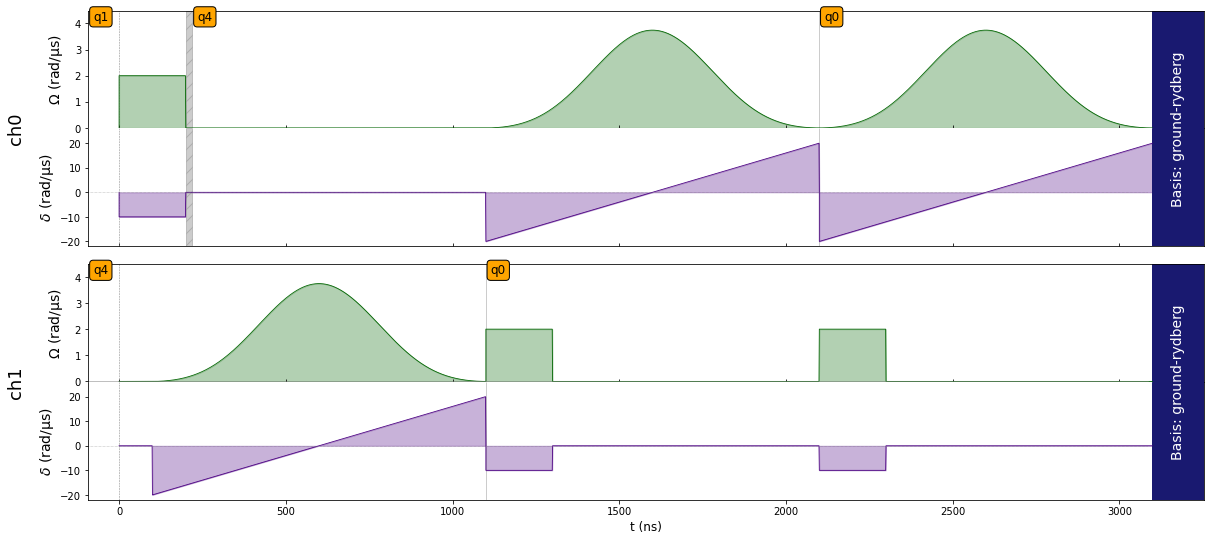

In [52]:
seq.draw()